# Objective

This Jupyter notebook demonstrates a simple application of the PuLP Python module to the Fifa 19 dataset shared on Kaggle using Pandas dataframe. Specifically, I seek to maximise the aggregate overall rating of players in a team constrained by a finite budget and team's playing style.

Dataset available here: https://www.kaggle.com/karangadiya/fifa19

## Step 1: Import Python modules for project

In [1]:
import pulp as p
import pandas as pd

## Step 2: Read data file

Rather than parsing the entire data file`archive.zip` into a Pandas dataframe, I specify a list `columns` that contains strings of column names I will consider in my optimisation problem to reduce memory size of my dataframe.

In [2]:
columns = ['Name', 'Age', 'Club', 'Wage', 'Overall', 'Potential', 'Position']

df = pd.read_csv('archive.zip', usecols=columns)

## Step 3: Data cleaning

Before we dive into analysis, I perform some pre-processing on the data to help with my analysis later.

In [3]:
# remove rows with missing values
df = df.dropna()

# lower case column names and replace space with underscore
df.columns = [column.lower().replace(' ', '_') for column in df.columns]

## Step 4: Exploratory analysis

In this section, I provide descriptive statistics on key variables.

### `overall` - player's overall rating

A summary of the top-rated players in Fifa 19:

In [4]:
df.sort_values('overall', ascending=False).head(10)[['name', 'overall', 'wage']]

,name,overall,wage
0,L. Messi,94,€565K
1,Cristiano Ronaldo,94,€405K
2,Neymar Jr,92,€290K
3,De Gea,91,€260K
4,K. De Bruyne,91,€355K
5,E. Hazard,91,€340K
6,L. Modrić,91,€420K
7,L. Suárez,91,€455K
8,Sergio Ramos,91,€380K
12,D. Godín,90,€125K


There aren't too many surprises here - from glancing at the table above, offensive players appear to be better remunerated than defensive players.

### `wage` - player's weekly wage

From the table above, we see that wage is suffixed by the Euro currency symbol "€" and prefixed by "K" representing one thousand. This is verified by viewing unique first and last characters:

In [5]:
df['wage'].str[0].unique(), df['wage'].str[-1].unique()

(array(['€'], dtype=object), array(['K'], dtype=object))

To compare wages among players, I remove the first and last characters of each observation. The data is subsequently rendered into `float` type.

In [6]:
def value_in_dollar(value):

    return float(value[1:-1]) * 1000

# denotes wage in dollar term
df['wage_dollar'] = df['wage'].apply(lambda row: value_in_dollar(row))

df.sort_values(by='wage_dollar', ascending=False).head(5)[['name', 'wage_dollar']]

,name,wage_dollar
0,L. Messi,565000.0
7,L. Suárez,455000.0
6,L. Modrić,420000.0
1,Cristiano Ronaldo,405000.0
8,Sergio Ramos,380000.0


From the table above, we see that "L. Messi" from FC Barcelona grosses €565k a week. In a distant second is teammate "L. Suárez" at €455k a week followed closely by rival player "L. Modrić" of Real Madrid.

### `position` - player's playing position

All possible positions are summarised as follows:

In [7]:
df['position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

For simplicity, I summarise playing positions across eight broad categories:

In [8]:
# create position category
def position_category(row):

    if row == 'GK':
        position = 'goalkeeper'
    elif row in ['RB', 'RWB']:
        position = 'right_back'
    elif row in ['LB', 'LWB']:
        position = 'left_back'
    elif 'CB' in row:
        position = 'center_back'
    elif row in ['RM', 'RW']:
        position = 'right_wing'
    elif row in ['LM', 'LW']:
        position = 'left_wing'
    elif any([pos in row for pos in ['AM', 'CM', 'DM']]):
        position = 'center_mid'
    else:
        position = 'forward'

    return position

# create position category
df['position_category'] = df['position'].apply(lambda row: position_category(row))

To verify the else-statement has captured appropriate `position` values for 'forward', I perform a groupby:

In [9]:
df.groupby('position_category')['position'].unique()

position_category
center_back                                  [RCB, CB, LCB]
center_mid     [RCM, LCM, LDM, CAM, CDM, LAM, RDM, CM, RAM]
forward                            [RF, ST, LF, RS, LS, CF]
goalkeeper                                             [GK]
left_back                                         [LB, LWB]
left_wing                                          [LW, LM]
right_back                                        [RB, RWB]
right_wing                                         [RM, RW]
Name: position, dtype: object

So far so good!

## Step 5: Linear Programming

### A: Create problem variable

Recall the optimisation problem is a maximisation problem. Therefore, the problem variable is initialised as:

In [10]:
# create problem variable
prob = p.LpProblem('overall_team', p.LpMaximize)

### B: Create decision variable

Decision variables are the quantity variables that will be determined to solve a optimisation problem. In this scenario, player is the decision variable represented by `df['name']` in my Pandas dataframe. 

Further, I provide bounds `lowBound=0` and `upBound=1` to represent a non-negativity lower bound (i.e. optimal solution cannot provide a negative quantity of a player) and upper bound of one (i.e. a player can be selected a maximum of one time), respectively, rather than specifying the bound as an explicit constrraint.

Lastly, I specify `cat='Integer'` as I only want integer weights. Noting the bounds I have provided above, my solution will only return a weight of nil (non-selection) or one (selection) for every player:

In [11]:
# create decision variable
names = p.LpVariable.dicts(name='x', indexs=df['name'], lowBound=0, upBound=1, cat='Integer')

### C: Create objective function

The objective function is to maximise the rating of players in a team:

In [12]:
# create dictionary with players' name as key and overall rating as key value
overall = dict(zip(df['name'], df['overall']))

# create objective function
prob += p.lpSum([overall[i] * names[i] for i in df['name']])

### D: Create constraints

Constraints are summarised as follows:

1.&emsp;Sum of players' wage must be less than club's wage budget.<br>
2.&emsp;Fixed number of players for playing positions.<br>
3.&emsp;No more than two players from the same club.

For constraint (1), I assume a wage budget of €261,500 which corresponds to the 75th percentile:

In [13]:
df.groupby('club')['wage_dollar'].sum().describe()

count    6.510000e+02
mean     2.720384e+05
std      4.994448e+05
min      1.900000e+04
25%      6.050000e+04
50%      1.080000e+05
75%      2.615000e+05
max      5.017000e+06
Name: wage_dollar, dtype: float64

Constraint (2) actually describes multiple constraints relating to number of desired players for each playing position. 

On average, clubs with a wage budget that fall between the 70th (€215,000) and 80th percentile (€355,000) have three goalkeepers, two right backs, two left backs, five center backs, two right wings, three left wings, seven center midfielders and four forwards. I design my constraints for player position requirements around these averages.

In [14]:
# create dictionary with players' name as key and wage as key value
wage = dict(zip(df['name'], df['wage_dollar']))

# create dictionary with players' name as key and position category as key value
position = dict(zip(df['name'], df['position_category']))

# create constraint for wage
prob += p.lpSum([wage[i] * names[i] for i in df['name']]) <= 261500

# create constraint for number of goalkeeper(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'goalkeeper']) == 3

# create constraint for number of right back(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'right_back']) == 2

# create constraint for number of left back(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'left_back']) == 2

# create constraint for number of center back(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'center_back']) == 5

# create constraint for number of right wing(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'right_wing']) == 2

# create constraint for number of left wing(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'left_wing']) == 3

# create constraint for number of center midfielders(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'center_mid']) == 7

# create constraint for number of forward(s)
prob += p.lpSum([names[i] for i in df['name'] if position[i] == 'forward']) == 4

# create dictionary with players' name as key and club as key value
club = dict(zip(df['name'], df['club']))

Constraint (3) specifies the maximum number of players from the same club to be no more than two:

In [15]:
# create constraint for number of players in same club
for club_name in df['club'].unique():
    prob += p.lpSum([names[i] for i in df['name'] if club[i] == club_name]) <= 2

### E: Run solver

Now that the decision variable, objective function and constraints are defined, I will solve for the optimisation problem:

In [16]:
# run solver
prob.solve()

1

Which corresponds to "Optimal" (i.e. optimal solution):

In [17]:
print('Mapping:', p.LpStatus)
print('Outcome:', p.LpStatus[prob.solve()])
print('Total overall rating:', prob.objective.value())

Mapping: {0: 'Not Solved', 1: 'Optimal', -1: 'Infeasible', -2: 'Unbounded', -3: 'Undefined'}
Outcome: Optimal
Total overall rating: 2277.0


The optimal decision consists of players that carry a non-zero weight (in this scenario, only weights of zero and one are applicable per my defined bounds for the decision variable). The following code saves player names into a dictionary `optimal_team`:

In [18]:
optimal_team = {}
for v in prob.variables():
    if v.varValue > 0:
        optimal_team[v] = v.varValue
        
print(optimal_team)

{x_Alex_Telles: 1.0, x_Anderson_Talisca: 1.0, x_B._Höwedes: 1.0, x_B._Natcho: 1.0, x_B._Schweinsteiger: 1.0, x_B._Verbič: 1.0, x_Bruno_Fernandes: 1.0, x_Casillas: 1.0, x_David_Villa: 1.0, x_E._Viviano: 1.0, x_Grimaldo: 1.0, x_I._Akinfeev: 1.0, x_Iniesta: 1.0, x_Jardel: 1.0, x_Léo_Matos: 1.0, x_M._de_Ligt: 1.0, x_Marlos: 1.0, x_Mário_Fernandes: 1.0, x_N._Gaitán: 1.0, x_P._Wernbloom: 1.0, x_R._Eremenko: 1.0, x_R._Zobnin: 1.0, x_S._Giovinco: 1.0, x_Taison: 1.0, x_V._Tsygankov: 1.0, x_V._Ćorluka: 1.0, x_Y._Carrasco: 1.0, x_Z._Ibrahimović: 1.0}


In [19]:
df[df['name'].isin([player.name[2:].replace('_', ' ') for player in optimal_team])]

,name,age,overall,potential,club,wage,position,wage_dollar,position_category
76,Iniesta,34,86,86,Vissel Kobe,€21K,LF,21000.0,forward
109,Z. Ibrahimović,36,85,85,LA Galaxy,€15K,RS,15000.0,forward
112,Alex Telles,25,84,87,FC Porto,€22K,LB,22000.0,left_back
114,Bruno Fernandes,23,84,88,Sporting CP,€22K,LCM,22000.0,center_mid
166,Anderson Talisca,24,83,90,Guangzhou Evergrande Taobao FC,€18K,CAM,18000.0,center_mid
173,Y. Carrasco,24,83,86,Dalian YiFang FC,€20K,LM,20000.0,left_wing
226,M. de Ligt,18,82,91,Ajax,€11K,RCB,11000.0,center_back
276,Mário Fernandes,27,82,82,PFC CSKA Moscow,€1K,RB,1000.0,right_back
286,Taison,30,82,82,Shakhtar Donetsk,€1K,LM,1000.0,left_wing
288,Marlos,30,82,82,Shakhtar Donetsk,€1K,RM,1000.0,right_wing


## Step 6: Evaluation of optimal solution

For a final exercise, I compare the overall rating of the optimal team (2277) with a budget at the 75th percentile of the Fifa 19 universe against clubs with a wage budget between the 75th percentile and 85th percentile. This comparison provides some insight into the efficiency of clubs' spending if we assume they are solely focused on maximising the overall rating of the team. In reality, this assumption is unlikely to hold as there are other factors (e.g. teamwork, loyalty, reputation, etc.) that contribute to players' selection not considered in my model.

I am cautious of an enlarged range as the overall rating for a team can increase with a larger wage budget by affording more players and not necessarily from the possession of higher-quality players.

Among 65 clubs, only Frosinone (2298; 80th percentile wage budget) and Sporting CP (2284; 85th percentile wage budget) demonstrate a higher aggregate overall rating (untabulated).

## Miscellaneous: Optimal overall team rating across different wages

In [24]:
class OptimalTeam:

    @staticmethod
    # create position category
    def position_category(row):

        if row == 'GK':
            position = 'goalkeeper'
        elif row in ['RB', 'RWB']:
            position = 'right_back'
        elif row in ['LB', 'LWB']:
            position = 'left_back'
        elif 'CB' in row:
            position = 'center_back'
        elif row in ['RM', 'RW']:
            position = 'right_wing'
        elif row in ['LM', 'LW']:
            position = 'left_wing'
        elif any([pos in row for pos in ['AM', 'CM', 'DM']]):
            position = 'center_mid'
        else:
            position = 'forward'

        return position

    # denotes players' market value in dollar term
    @staticmethod
    def value_in_dollar(value):
        return float(value[1:-1]) * 1000

    def __init__(self):

        columns = ['Name', 'Age', 'Club', 'Wage', 'Overall', 'Potential', 'Position']

        self.df = pd.read_csv('archive.zip', usecols=columns)

        # remove rows with missing values
        self.df = self.df.dropna()

        # lower case column names and replace space with underscore
        self.df.columns = [column.lower().replace(' ', '_') for column in self.df.columns]

        # denotes wage in dollar term
        self.df['wage_dollar'] = self.df['wage'].apply(lambda row: self.value_in_dollar(row))

        # create position category
        self.df['position_category'] = self.df['position'].apply(lambda row: self.position_category(row))

    def maximise_overall(self, max_wage):

        df_copy = self.df.copy()

        # create dictionary with players' name as key and overall rating as key value
        overall = dict(zip(df_copy['name'], df_copy['overall']))

        # create dictionary with players' name as key and wage as key value
        wage = dict(zip(df_copy['name'], df_copy['wage_dollar']))

        # create dictionary with players' name as key and position category as key value
        position = dict(zip(df_copy['name'], df_copy['position_category']))

        # create problem variable
        prob = p.LpProblem('overall_team', p.LpMaximize)

        # create decision variable
        names = p.LpVariable.dicts(name='x', indexs=df_copy['name'], lowBound=0, upBound=1, cat='Integer')

        # create objective function
        prob += p.lpSum([overall[i] * names[i] for i in df_copy['name']])

        # create constraint for wage
        prob += p.lpSum([wage[i] * names[i] for i in df_copy['name']]) <= max_wage

        # create constraint for number of goalkeeper(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'goalkeeper']) == 3

        # create constraint for number of right back(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'right_back']) == 2

        # create constraint for number of left back(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'left_back']) == 2

        # create constraint for number of center back(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'center_back']) == 5

        # create constraint for number of right wing(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'right_wing']) == 2

        # create constraint for number of left wing(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'left_wing']) == 3

        # create constraint for number of center midfielders(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'center_mid']) == 7

        # create constraint for number of forward(s)
        prob += p.lpSum([names[i] for i in df_copy['name'] if position[i] == 'forward']) == 4

        # create dictionary with players' name as key and club as key value
        club = dict(zip(df_copy['name'], df_copy['club']))

        # create constraint for number of players in same club
        for club_name in df_copy['club'].unique():
            prob += p.lpSum([names[i] for i in df_copy['name'] if club[i] == club_name]) <= 2
            
        # run solver
        prob.solve()

        return prob


# store optimal value across different wages into dictionary
optimal_team = OptimalTeam()

wage_score = {}
start_wage = 100000
end_wage = 2000000
step_wage = 100000
for wage in range(start_wage, end_wage + step_wage, step_wage):
    prob_wage = optimal_team.maximise_overall(max_wage=wage)

    # optimal solution only
    if prob_wage.status == 1:
        wage_score[wage] = prob_wage.objective.value()

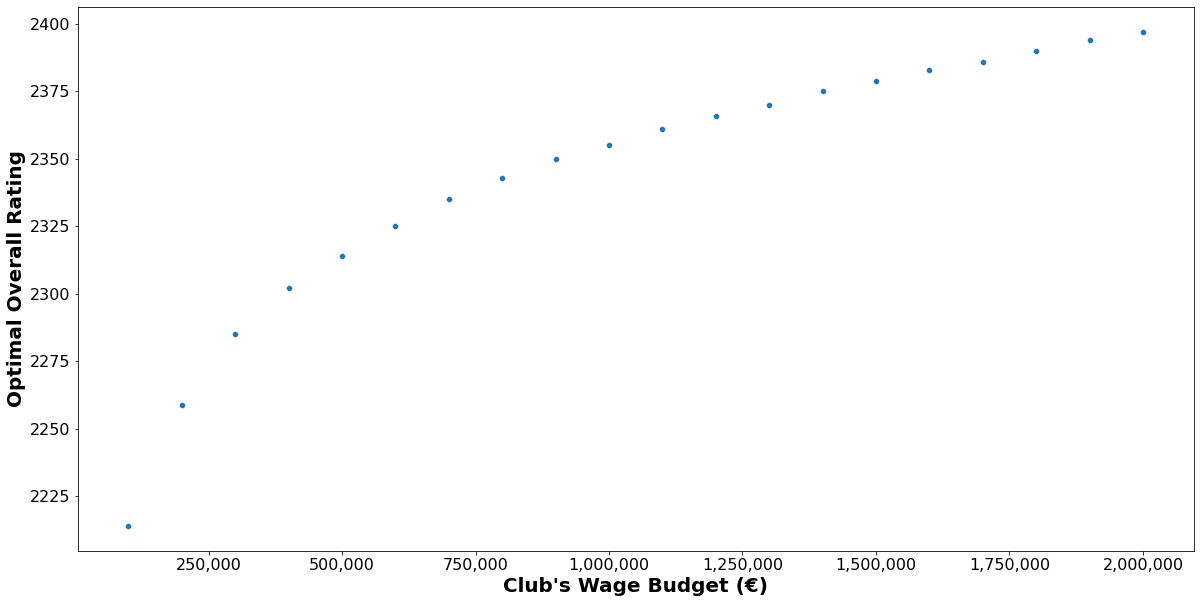

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x=wage_score.keys(), y=wage_score.values(), ax=ax)
ax.set_ylabel('Optimal Overall Rating', fontsize=20, fontweight='bold')
ax.set_xlabel('Club\'s Wage Budget (€)', fontsize=20, fontweight='bold')
ax.tick_params(axis="y", labelsize=16)
ax.tick_params(axis="x", labelsize=16)
ax.xaxis.set_major_formatter('{x:,.0f}')

Not surprisingly, optimal overall rating increases with a larger wage budget as more players are available for selection. Although, the rate of increase decreases towards the higher-end wage budget because of fewer addition of new players with significant wages.